In [ ]:
!pip install tiatoolbox

In [ ]:
import pickle
import torch
import torchvision.transforms as T
from tiatoolbox.models.architecture import get_pretrained_model, fetch_pretrained_weights
from tiatoolbox.models import IOPatchPredictorConfig
from umap import UMAP
from PIL import Image

In [ ]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

In [ ]:
!apt-get install -y libpixman-1-dev

In [ ]:
# for downloading datasets from zenodo:
# !pip install zenodo-get

In [ ]:
from tiatoolbox.models.architecture import get_pretrained_model, fetch_pretrained_weights
from tiatoolbox.models import IOPatchPredictorConfig
# get resnet34 pretrained on PCam dataset by TIA team
model, config = get_pretrained_model(pretrained_model='resnet101-kather100k')

In [ ]:
import torch
import torchvision
import torchvision.transforms as T

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)

In [ ]:
transform_kather = T.Compose([
    T.ToTensor(),
])

dataset = ImageFolderWithPaths('/content/drive/MyDrive/th2023/Kather_texture_2016_image_tiles_5000', transform=transform_kather)

In [ ]:
img, label, path = dataset[1000]

In [ ]:
state_dict = torch.load('/content/resnet101-kather100k.pth')

In [ ]:
encoder = torch.nn.Sequential(*(list(model.children())[:-1]))

with open('/content/drive/MyDrive/th2023/model.pkl', 'wb') as d:
  pickle.dump(encoder, d)

In [ ]:
type(encoder)

torch.nn.modules.container.Sequential

In [ ]:
# del encoder
encoder = torch.nn.Sequential(*(list(model.children())[:-1]))
encoder = encoder.to('cuda:0')
encoder

In [ ]:
len(dataset)

5000

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=128,
                                         shuffle=True,
                                         num_workers=2)

In [ ]:
import numpy as np

In [ ]:
locations = []
representations = []
predictions = []
for index, (images, labels, paths) in enumerate(dataloader):
  images = images.to('cuda:0')
  reps = encoder(images).detach().cpu().numpy()
  representations.append(reps)
  predictions.extend([int(l.item()) for l in labels])
  locations.extend(paths)
  del reps
  print(index)

In [ ]:
representations = np.vstack([np.squeeze(r) for r in representations])
data = {
    "path": locations,
    "representation": representations,
    "label": predictions,
    "x": [],
    "y": [],
    "z": [],
    "UMAP": None,
}

In [ ]:
from umap import UMAP
import pickle
import numpy as np

with open('/content/drive/MyDrive/th2023/scratch/data3d.pkl', 'rb') as p:
  data = pickle.load(p)

data.keys()

In [ ]:
[(key, type(data[key][0])) for key in set(data) - {'UMAP', 'DBSCAN'}]

In [ ]:
[(key, len(data[key])) for key in set(data) - {'UMAP', 'DBSCAN'}]

In [ ]:
data['label'] = [str(l) for l in data['label']]
data['x'] = [float(c) for c in data['x']]
data['y'] = [float(c) for c in data['y']]
data['z'] = [float(c) for c in data['z']]
data['cluster'] = [str(l) for l in data['cluster']]

In [ ]:
emb = np.column_stack([data['x'], data['y'], data['z']])

In [ ]:
emb.shape

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.5, min_samples=15).fit(emb)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

d['cluster'] = labels

In [ ]:
d['cluster'] = labels

In [ ]:
from umap import UMAP

reducer = UMAP(n_neighbors=3, random_state=444, n_components=3).fit(representations)
data['x'] = reducer.embedding_[:, 0]
data['y'] = reducer.embedding_[:, 1]
data['z'] = reducer.embedding_[:, 2]
data['UMAP'] = reducer

In [ ]:
data.keys()

dict_keys(['path', 'representation', 'label', 'x', 'y', 'z', 'UMAP', 'cluster', 'DBSCAN'])

In [ ]:
del data['representation']
del data['UMAP']
del data['DBSCAN']

In [ ]:
with open('')

In [ ]:
import copy
d = copy.deepcopy(data)

In [ ]:
del d['UMAP']
del d['representation']

In [ ]:
import pandas as pd
import plotly.express as px
# df = px.data.iris()
df = pd.DataFrame.from_dict(d)
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label')
fig.update_traces(
    marker=dict(size=1.5, symbol="circle"),
    selector=dict(mode="markers"),
)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
import copy
# df = px.data.iris()
df = pd.DataFrame.from_dict(d)
df["cluster"] = df["cluster"].astype(str)
df["label"] = df["label"].astype(str)
fig = px.scatter_3d(df, x='x', y='y', z='z', color='cluster')
fig.update_traces(
    marker=dict(size=1.5, symbol="circle"),
    selector=dict(mode="markers"),
)
fig.show()

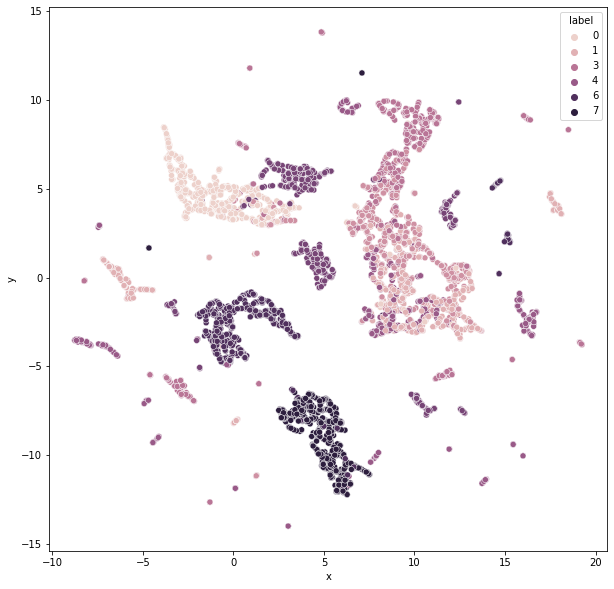

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
import pickle

with open('/content/drive/MyDrive/th2023/scratch/data3d.pkl', 'wb') as d:
  pickle.dump(data, d)

In [ ]:
data.keys()

dict_keys(['path', 'label', 'x', 'y', 'z', 'cluster'])

In [ ]:
with open('/content/drive/MyDrive/th2023/scratch/sanity.pkl', 'wb') as d:
  pickle.dump(data, d)

In [ ]:
data['DBSCAN'] = db
data['cluster'] = labels

In [ ]:
!python --version

Python 3.8.10
